In [1]:
import numpy as np
import shutil
import os
import glob
import pandas as pd
import matplotlib.pylab as plt
import pickle
import sys
% matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
import itertools
from scipy import interp
from itertools import cycle, islice
from keras.utils import np_utils

# Some preprocessing utilities
from sklearn.utils import shuffle
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE,ADASYN

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# The different classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, classification_report, confusion_matrix,balanced_accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score

# Root directory of the project
ROOT_DIR = os.path.abspath("../code")
# Import code
sys.path.append(ROOT_DIR)

from hierarchicalmodel import *
from preprocessing import *
from prediction import *
from optimisation import *
from utils import *

Using TensorFlow backend.
//anaconda/envs/tflearn/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
//anaconda/envs/tflearn/lib/python3.5/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
nFeatures = 7

# The directory to save the files
plots_dir                 = '../results/hyperopt_hierarchical-results_SMOTE/plots/'
results_dir               = '../results/hyperopt_hierarchical-results_SMOTE/results/'
misclassify_dir           = r'../results/hyperopt_hierarchical-results_SMOTE/results/Misclassification_'


eclipsing_label = 20;rotational_label = 21;pulsating_label = 22;RR_Lyrae_label = 23; LPV_label = 24;\
delta_scuti_label = 25; cepheids_label = 26

true_class_1=1;true_class_2=2;true_class_3=3;true_class_4=4;true_class_5=5;true_class_6=6;true_class_7=7;\
true_class_8=8;true_class_9=9;true_class_10=10;true_class_11=11;true_class_12=12;true_class_13=13
n_splits         = 5
data_preparation = False
multi_class      = True
augmentation     = True
save_model       = False
load_model       = False



acc_xgb_FL = [];mcc_xgb_FL = [];acc_rf_FL = [];mcc_rf_FL = [];\
acc_xgb_SL_EB = [];mcc_xgb_SL_EB = [];acc_rf_SL_EB = [];mcc_rf_SL_EB = [];\
acc_xgb_SL_RLCD = [];mcc_xgb_SL_RLCD = [];acc_rf_SL_RLCD = [];mcc_rf_SL_RLCD = [];\
acc_xgb_TL_RL = [];mcc_xgb_TL_RL = [];acc_rf_TL_RL = [];mcc_rf_TL_RL = [];\
acc_xgb_TL_Cep = [];mcc_xgb_TL_Cep = [];acc_rf_TL_Cep = [];mcc_rf_TL_Cep = []

In [4]:
train_dir = '../data/training_set_features/'
test_dir  = '../data/test_set_features/'

# Load features for the different variable stars
features_1_tr  = pd.read_csv(train_dir+'Type'+str(true_class_1)+'_features.csv')
features_2_tr  = pd.read_csv(train_dir+'Type'+str(true_class_2)+'_features.csv')
features_3_tr  = pd.read_csv(train_dir+'Type'+str(true_class_3)+'_features.csv')
features_4_tr  = pd.read_csv(train_dir+'Type'+str(true_class_4)+'_features.csv')
features_5_tr  = pd.read_csv(train_dir+'Type'+str(true_class_5)+'_features.csv')
features_6_tr  = pd.read_csv(train_dir+'Type'+str(true_class_6)+'_features.csv')
features_7_tr  = pd.read_csv(train_dir+'Type'+str(true_class_7)+'_features.csv')
features_8_tr  = pd.read_csv(train_dir+'Type'+str(true_class_8)+'_features.csv')
features_9_tr  = pd.read_csv(train_dir+'Type'+str(true_class_9)+'_features.csv')
features_10_tr = pd.read_csv(train_dir+'Type'+str(true_class_10)+'_features.csv')
features_12_tr = pd.read_csv(train_dir+'Type'+str(true_class_12)+'_features.csv')

features_1_te  = pd.read_csv(test_dir+'Type'+str(true_class_1)+'_features.csv')
features_2_te  = pd.read_csv(test_dir+'Type'+str(true_class_2)+'_features.csv')
features_3_te  = pd.read_csv(test_dir+'Type'+str(true_class_3)+'_features.csv')
features_4_te  = pd.read_csv(test_dir+'Type'+str(true_class_4)+'_features.csv')
features_5_te  = pd.read_csv(test_dir+'Type'+str(true_class_5)+'_features.csv')
features_6_te  = pd.read_csv(test_dir+'Type'+str(true_class_6)+'_features.csv')
features_7_te  = pd.read_csv(test_dir+'Type'+str(true_class_7)+'_features.csv')
features_8_te  = pd.read_csv(test_dir+'Type'+str(true_class_8)+'_features.csv')
features_9_te  = pd.read_csv(test_dir+'Type'+str(true_class_9)+'_features.csv')
features_10_te = pd.read_csv(test_dir+'Type'+str(true_class_10)+'_features.csv')
features_12_te = pd.read_csv(test_dir+'Type'+str(true_class_12)+'_features.csv')


X_training = shuffle(pd.concat([features_1_tr,features_2_tr,features_3_tr,features_4_tr,features_5_tr,\
            features_6_tr,features_7_tr,features_8_tr,features_9_tr,features_10_tr,features_12_tr],\
            ignore_index=True))


X_testing = shuffle(pd.concat([features_1_te,features_2_te,features_3_te,features_4_te,features_5_te,\
            features_6_te,features_7_te,features_8_te,features_9_te,features_10_te,features_12_te],\
            ignore_index=True))

print('The training set contains {} samples'.format(X_training.shape[0]))
print('The test set contains {} samples'.format(X_testing.shape[0]))


The training set contains 16195 samples
The test set contains 21242 samples


In [5]:
period_data = pd.read_csv('../data/catalogue/SSS_Per_Tab.txt', delim_whitespace=True,\
names       = ["File_Name", "RA", "Dec", "Period", "V_CSS", "Npts", "V_amp", "Type", "Prior_ID"])

period_data.head()

,File_Name,RA,Dec,Period,V_CSS,Npts,V_amp,Type,Prior_ID
0,3039001008411,0.10758,-39.61419,0.514380,14.709183,230,0.260621,5,NaN
1,3041001010523,0.13228,-41.48192,0.589281,19.164993,145,0.829397,1,NaN
2,3025001011039,0.15796,-25.18378,0.616695,17.559777,147,0.485934,1,NaN
3,3043001016067,0.18672,-43.13301,0.333486,15.206383,212,0.371547,2,NaN
4,3029001015115,0.20548,-28.81702,0.583042,14.818986,196,0.832350,1,TZ


In [6]:
periods                 = period_data[['File_Name', 'Period']]
X_training['File_Name'] = X_training['File_Name'].astype(int)
X_testing['File_Name']  = X_testing['File_Name'].astype(int)


In [7]:
training_set            = X_training.join(periods.set_index('File_Name'), on='File_Name')
training_set            = training_set[['0','1','2','3','4','5','Period', 'File_Name', 'True_class_labels']]
training_set.head()

,0,1,2,3,4,5,Period,File_Name,True_class_labels
14882,-0.024851,14.388986,0.102824,-0.959183,0.176500,0.007146,0.503952,3021115022886,7
9247,0.407355,18.019328,0.223624,-0.360300,0.436656,0.012410,0.336307,3063070006531,5
3789,-0.168961,14.323500,0.095889,-1.354815,0.146175,0.006695,0.274335,3021038017913,2
12443,-0.300323,14.095937,0.054647,-0.456309,0.095500,0.003877,62.519537,3039113066894,7
11082,1.535700,13.699016,0.068747,4.345631,0.157750,0.005018,1.567850,3033097033950,6


In [8]:
testing_set = X_testing.join(periods.set_index('File_Name'), on='File_Name')
testing_set = testing_set[['0','1','2','3','4','5','Period', 'File_Name', 'True_class_labels']]
testing_set.iloc[150:155,:]

,0,1,2,3,4,5,Period,File_Name,True_class_labels
12187,0.346488,15.290520,0.105791,-0.901724,0.180375,0.006919,0.554206,3033088048047,5
9368,0.640841,17.023052,0.169983,-0.245374,0.309336,0.009985,0.336832,3031069022011,5
11608,0.613165,15.280914,0.200572,-0.418957,0.317175,0.013126,0.291722,3027072016446,5
11110,0.999301,13.642554,0.163294,-0.171890,0.272800,0.011969,0.338347,3027012018831,5
5459,0.594673,16.778659,0.177683,-0.700850,0.304650,0.010590,0.376045,3045074104587,5


In [9]:
RRab_train        = stars_label(training_set, true_class_1, column_name='True_class_labels')
RRc_train         = stars_label(training_set, true_class_2, column_name='True_class_labels') 
RRd_train         = stars_label(training_set, true_class_3, column_name='True_class_labels')
blazhko_train     = stars_label(training_set, true_class_4, column_name='True_class_labels')
contact_Bi_train  = stars_label(training_set, true_class_5, column_name='True_class_labels')
semi_det_Bi_train = stars_label(training_set, true_class_6, column_name='True_class_labels')
rot_train         = stars_label(training_set, true_class_7, column_name='True_class_labels')
LPV_train         = stars_label(training_set, true_class_8, column_name='True_class_labels')
delta_scuti_train = stars_label(training_set, true_class_9, column_name='True_class_labels')
ACEP_train        = stars_label(training_set, true_class_10, column_name='True_class_labels')
cep_ii_train      = stars_label(training_set, true_class_12, column_name='True_class_labels')

RRab_test        = stars_label(testing_set, true_class_1, column_name='True_class_labels')
RRc_test         = stars_label(testing_set, true_class_2, column_name='True_class_labels') 
RRd_test         = stars_label(testing_set, true_class_3, column_name='True_class_labels')
blazhko_test     = stars_label(testing_set, true_class_4, column_name='True_class_labels')
contact_Bi_test  = stars_label(testing_set, true_class_5, column_name='True_class_labels')
semi_det_Bi_test = stars_label(testing_set, true_class_6, column_name='True_class_labels')
rot_test         = stars_label(testing_set, true_class_7, column_name='True_class_labels')
LPV_test         = stars_label(testing_set, true_class_8, column_name='True_class_labels')
delta_scuti_test = stars_label(testing_set, true_class_9, column_name='True_class_labels')
ACEP_test        = stars_label(testing_set, true_class_10, column_name='True_class_labels')
cep_ii_test      = stars_label(testing_set, true_class_12, column_name='True_class_labels')



In [10]:
'-----------------------------------------------------------------------------'
                                # FIRST LAYER
'-----------------------------------------------------------------------------'
training_data_FL, testing_data_FL, y_FL_training_counts = first_layer(contact_Bi_train, semi_det_Bi_train,rot_train,RRab_train, RRc_train, RRd_train, blazhko_train, LPV_train, delta_scuti_train, ACEP_train, cep_ii_train,\
    contact_Bi_test, semi_det_Bi_test,rot_test,RRab_test, RRc_test, RRd_test, blazhko_test, LPV_test, delta_scuti_test, ACEP_test, cep_ii_test,\
    eclipsing_label,rotational_label,pulsating_label)

X_train_FL, y_train_FL, X_test_FL, y_test_FL = smote_augmentation(training_data_FL, testing_data_FL, label='New_label',nFeatures=nFeatures,aug_tech='SMOTE',augmentation=True)#aug_tech='ADASYN'

if multi_class:
    classes_types_FL = ['Eclipsing','Rotational','Pulsating']
    types_FL         ='Type_FL'
    nClasses_FL      = len(classes_types_FL)

else:
    classes_types_FL = ['Eclipsing','Rotational']
    types_FL         ='Type_Binary'
    nClasses_FL      = 2
    

X_tr = X_train_FL; y_tr=y_train_FL

eclipsing_binary_train has (6312, 9)
pulsating_train has (7338, 9)
rotational_train has (2545, 9)
eclipsing_binary_test has (17000, 9)
pulsating_test has (3151, 9)
rotational_test has (1091, 9)
Before OverSampling, counts of label 20: (6312,)
Before OverSampling, counts of label 21: (2545,)
Before OverSampling, counts of label 22: (7338,)
----------------------------------------------------------------------
After OverSampling, counts of label 20: (7338,)
After OverSampling, counts of label 21: (7338,)
After OverSampling, counts of label 22: (7338,)


In [11]:
def objectives_xgb(space):
    classifier = XGBClassifier(objective = space['objective'],max_depth=space['max_depth'],eta = space['eta'],\
                               subsample = space['subsample'])        
    classifier.fit(X_tr, y_tr)    
    accuracies   = cross_val_score(estimator=classifier, X=X_tr, y=y_tr, cv=StratifiedKFold(n_splits=n_splits),scoring='balanced_accuracy')
    CrossValMean = accuracies.mean()
    print("Accuracy {:.3f} params {}".format(CrossValMean, space))
    return{'loss':1-CrossValMean, 'status': STATUS_OK }

def objectives_rf(space):
    classifier = RandomForestClassifier(min_samples_split=space['min_samples_split'],n_estimators = space['n_estimators'],\
                                class_weight=space['class_weight'],max_features=space['max_features'])        
    classifier.fit(X_tr, y_tr)
    accuracies   = cross_val_score(estimator=classifier, X=X_tr, y=y_tr, cv=StratifiedKFold(n_splits=n_splits),scoring='balanced_accuracy')
    CrossValMean = accuracies.mean()
    print("Accuracy {:.3f} params {}".format(CrossValMean, space))
    return{'loss':1-CrossValMean, 'status': STATUS_OK }


def hyperparameter_optimization_xgb(multi=False):
    if multi:
        objective = 'multi:softmax'
    else:
        objective = 'binary:logistic'
        
    space ={'objective':objective,'max_depth':hp.choice('max_depth', np.arange(1,15,dtype=int)),\
                    'eta': hp.quniform ('eta', 0.0, 0.09, 0.01),'subsample': hp.quniform ('x_subsample', 0.4,0.8,0.1)}
    trials         = Trials()
    opt_parameters = fmin(fn=objectives_xgb,space=space,algo=tpe.suggest,max_evals=5,trials=trials)
    print(opt_parameters)
    
    best_params = space_eval(space, opt_parameters)
    print("BEST PARAMETERS: " + str(best_params))
    
    return best_params

def hyperparameter_optimization_rf(multi=False):
    space ={'min_samples_split':hp.choice('min_samples_split', np.arange(2,20,dtype=int)),\
            'n_estimators': hp.choice('n_estimators', [50,150,250,350,450,550,650,750,850,950]),\
            'class_weight':hp.choice('class_weight', ['balanced']),\
            'max_features':hp.choice('max_features', ['auto', 'sqrt', 'log2']) }
    trials         = Trials()
    opt_parameters = fmin(fn=objectives_rf,space=space,algo=tpe.suggest,max_evals=5,trials=trials)
    print(opt_parameters)
    
    best_params = space_eval(space, opt_parameters)
    print("BEST PARAMETERS: " + str(best_params))
    
    return best_params


def analysis_XGB(X_train, y_train, types,save_model=False,multi=False):
    opt_parameters_XGB = hyperparameter_optimization_xgb(multi=multi)
    print(opt_parameters_XGB)
    fit_model_XGB = model_save(XGBClassifier(**opt_parameters_XGB), X_train=X_train, y_train=y_train,\
                           filename_model= results_dir + types + '_XGB_model.sav', save_model=save_model)
    return opt_parameters_XGB, fit_model_XGB

def analysis_RF(X_train, y_train, types,save_model=False,multi=False):
    opt_parameters_RF = hyperparameter_optimization_rf(multi=multi)
    print(opt_parameters_RF)
    fit_model_RF = model_save(RandomForestClassifier(**opt_parameters_RF), X_train=X_train, y_train=y_train,\
                           filename_model= results_dir + types + '_RF_model.sav', save_model=save_model)
    return opt_parameters_RF, fit_model_RF


def final_prediction_XGB(fitModel,X_train, y_train, X_test, y_test, testing_set,classes, types,nClasses,load_model=False):
    ypred, accuracy, MCC, conf_mat, misclassified  = model_fit(fitModel,filename_model= results_dir + types +'_XGB_model.sav', X_train=X_train, y_train=y_train, X_test = X_test, y_test=y_test,\
                                                 classifier_model='XGBoost Classifier',classes=classes, filename =results_dir + types +'_XGB', load_model=load_model)
    misclassified_data, new_DF = find_misclassification(misclassified,y_test, test_data=testing_set,ypred=ypred, save_dir=results_dir + types +'Misclassification_XGB.csv')

    plotting = plot(conf_mat, classes_types=classes, classifier_model='XGBoost Classifier',\
                                  plot_title= plots_dir + types +'_XGB', X_test=X_test, y_test=y_test, nClasses=nClasses,cmap=plt.cm.Blues)
    
    fpr,tpr,roc_auc=plot_ROC_curve(X_test, y_test, nClasses=nClasses, fit_model=fitModel,plots_dir=plots_dir+types,classes_types=classes)

    return ypred, accuracy, MCC, conf_mat, new_DF, misclassified, fpr,tpr,roc_auc

def final_prediction_RF(fitModel,X_train, y_train, X_test, y_test, testing_set,classes, types,nClasses,load_model=False):
    ypred, accuracy, MCC, conf_mat, misclassified  = model_fit(fitModel,filename_model= results_dir + types +'_RF_model.sav', X_train=X_train, y_train=y_train, X_test = X_test, y_test=y_test,\
                                                 classifier_model='RF Classifier',classes=classes, filename =results_dir + types +'_RF', load_model=load_model)
    misclassified_data, new_DF = find_misclassification(misclassified,y_test, test_data=testing_set,ypred=ypred, save_dir=results_dir + types +'Misclassification_RF.csv')

    plotting = plot(conf_mat, classes_types=classes, classifier_model='RF Classifier',\
                                  plot_title= plots_dir + types +'_RF', X_test=X_test, y_test=y_test, nClasses=nClasses,cmap=plt.cm.Blues)
    fpr,tpr,roc_auc=plot_ROC_curve(X_test, y_test, nClasses=nClasses, fit_model=fitModel,plots_dir=plots_dir+types,classes_types=classes)

    return ypred, accuracy, MCC, conf_mat, new_DF, misclassified,fpr,tpr,roc_auc




Accuracy 0.784 params {'objective': 'multi:softmax', 'eta': 0.03, 'subsample': 0.4, 'max_depth': 7}
Accuracy 0.788 params {'objective': 'multi:softmax', 'eta': 0.05, 'subsample': 0.7000000000000001, 'max_depth': 8}
Accuracy 0.791 params {'objective': 'multi:softmax', 'eta': 0.0, 'subsample': 0.6000000000000001, 'max_depth': 8}
Accuracy 0.797 params {'objective': 'multi:softmax', 'eta': 0.04, 'subsample': 0.4, 'max_depth': 10}
Accuracy 0.764 params {'objective': 'multi:softmax', 'eta': 0.03, 'subsample': 0.8, 'max_depth': 4}
{'max_depth': 9, 'x_subsample': 0.4, 'eta': 0.04}
BEST PARAMETERS: {'objective': 'multi:softmax', 'eta': 0.04, 'subsample': 0.4, 'max_depth': 10}
{'objective': 'multi:softmax', 'eta': 0.04, 'subsample': 0.4, 'max_depth': 10}
Test set has shape (21242, 11)
Misclassified data has shape (5945, 11)
New test set has shape (15297, 11)
Normalized confusion matrix
[[0.68811765 0.21611765 0.09576471]
 [0.11640697 0.75893676 0.12465628]
 [0.04950809 0.07108854 0.87940336]]


//anaconda/envs/tflearn/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
//anaconda/envs/tflearn/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
//anaconda/envs/tflearn/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 576x432 with 0 Axes>

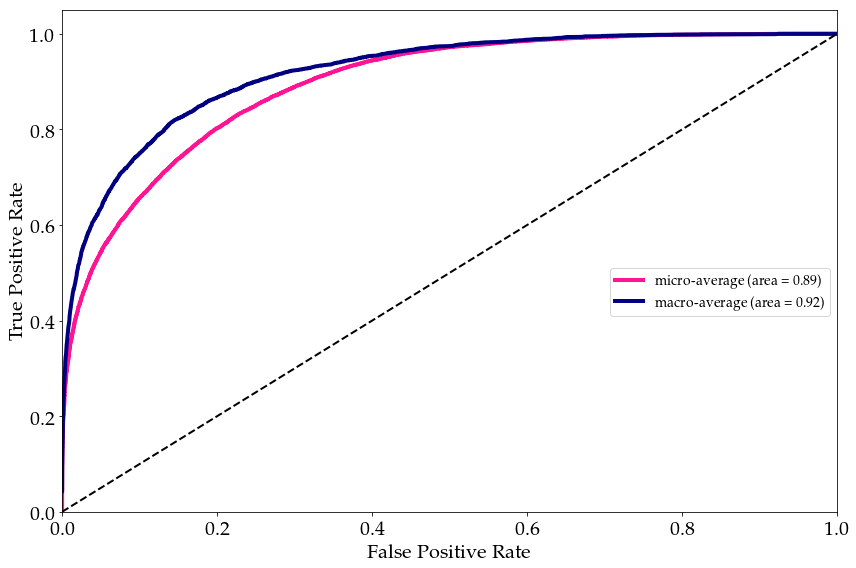

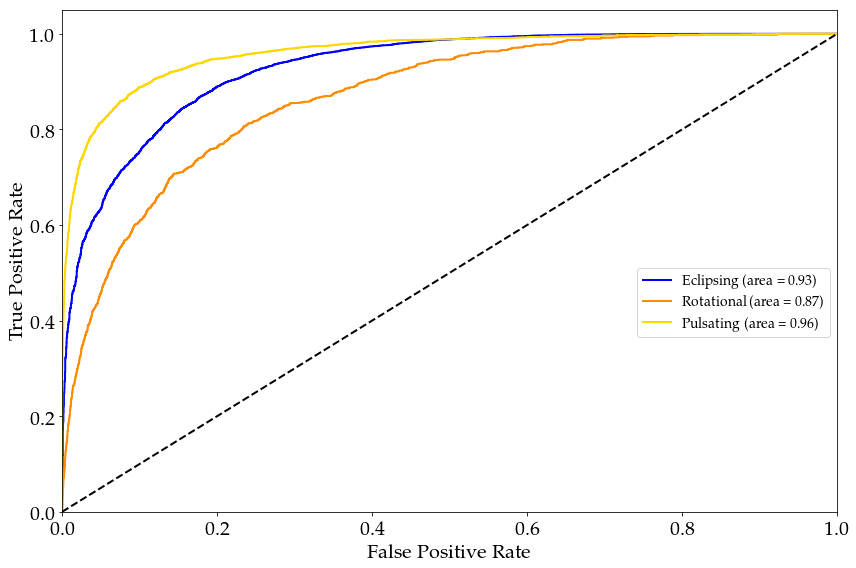

Accuracy 0.810 params {'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 550}
Accuracy 0.796 params {'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_split': 13, 'n_estimators': 650}
Accuracy 0.803 params {'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 6, 'n_estimators': 250}
Accuracy 0.797 params {'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 250}
Accuracy 0.802 params {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_split': 7, 'n_estimators': 850}
{'class_weight': 0, 'max_features': 2, 'min_samples_split': 1, 'n_estimators': 5}
BEST PARAMETERS: {'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 550}
{'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 550}
Test set has shape (21242, 11)
Misclassified data has shape (5898, 11)
New test set has shape (15344, 1

<Figure size 576x432 with 0 Axes>

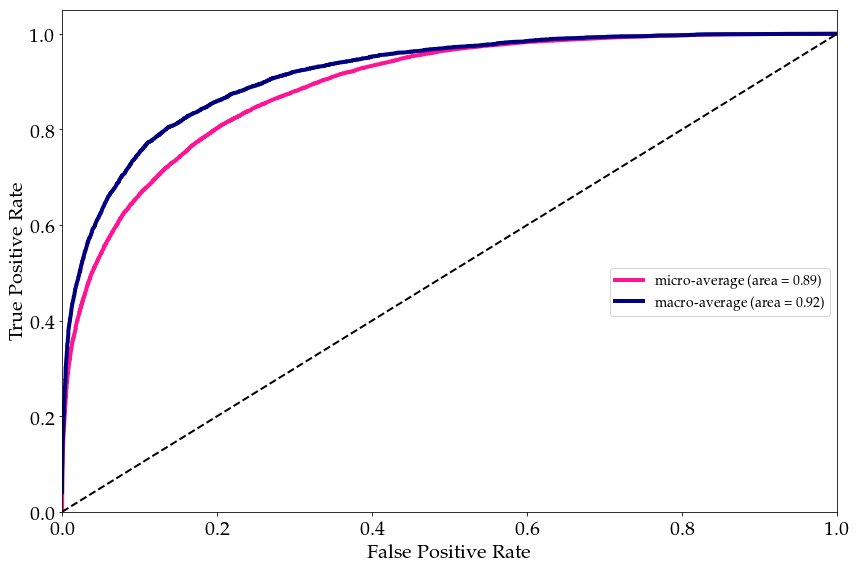

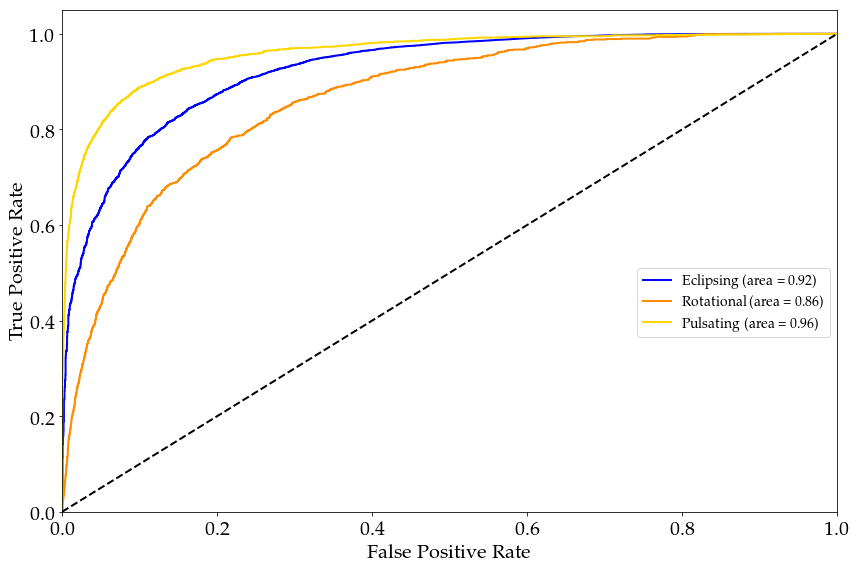

In [12]:
# XGBoost Classifier   
opt_xgb_FL, fit_model_xgb_FL = analysis_XGB(X_train_FL,y_train_FL, types_FL, save_model,multi=True) # This part can be commented when no training
ypred_xgb_FL, accuracy_xgb_FL, MCC_xgb_FL, conf_mat_xgb_FL,new_DF_xgb_FL, misclassified_xgb_FL,fpr_xgb_FL,tpr_xgb_FL,roc_auc_xgb_FL  = final_prediction_XGB(fit_model_xgb_FL, X_train_FL, y_train_FL, X_test_FL, y_test_FL, testing_data_FL, classes_types_FL, types_FL, nClasses_FL, load_model)         


opt_rf_FL, fit_model_rf_FL = analysis_RF(X_train_FL,y_train_FL, types_FL, save_model,multi=True) # This part can be commented when no training
ypred_rf_FL, accuracy_rf_FL, MCC_rf_FL, conf_mat_rf_FL,new_DF_rf_FL, misclassified_rf_FL,fpr_rf_FL,tpr_rf_FL,roc_auc_rf_FL  = final_prediction_RF(fit_model_rf_FL, X_train_FL, y_train_FL, X_test_FL, y_test_FL, testing_data_FL, classes_types_FL, types_FL, nClasses_FL, load_model)         


acc_xgb_FL.append(accuracy_xgb_FL)
mcc_xgb_FL.append(MCC_xgb_FL)

acc_rf_FL.append(accuracy_rf_FL)
mcc_rf_FL.append(MCC_rf_FL)

In [13]:
'-------------------------------------------------------------------------------'
                        # SECOND LAYER ECLIPSING BINARY
'-------------------------------------------------------------------------------'
training_data_SL_EB, testing_data_SL_EB, y_SL_EB_training_counts = second_layer_EB(contact_Bi_train,semi_det_Bi_train,contact_Bi_test,semi_det_Bi_test,true_class_5,true_class_6)
testing_set_SL_EB                                                = testing_data_SL_EB

X_train_SL_EB, y_train_SL_EB, X_test_SL_EB, y_test_SL_EB = smote_augmentation(training_data_SL_EB, testing_set_SL_EB,label='True_class_labels', nFeatures=nFeatures, aug_tech='SMOTE', augmentation=True)

# Random Forest Classifier    
classes_types_SL_EB = ['Ecl','EA']
types_SL_EB         ='Type_SL_Ecl_EA'
nClasses_SL_EB      = 2

X_tr = X_train_SL_EB; y_tr=y_train_SL_EB


ecl train has (3156, 9)
EA_train has (3156, 9)
ecl_test has (15647, 9)
EA_test has (1353, 9)
Before OverSampling, counts of label 5: (3156,)
Before OverSampling, counts of label 6: (3156,)
----------------------------------------------------------------------
After OverSampling, counts of label 5: (3156,)
After OverSampling, counts of label 6: (3156,)


Accuracy 0.933 params {'objective': 'binary:logistic', 'eta': 0.06, 'subsample': 0.8, 'max_depth': 11}
Accuracy 0.936 params {'objective': 'binary:logistic', 'eta': 0.02, 'subsample': 0.7000000000000001, 'max_depth': 3}
Accuracy 0.935 params {'objective': 'binary:logistic', 'eta': 0.01, 'subsample': 0.6000000000000001, 'max_depth': 2}
Accuracy 0.931 params {'objective': 'binary:logistic', 'eta': 0.07, 'subsample': 0.4, 'max_depth': 13}
Accuracy 0.935 params {'objective': 'binary:logistic', 'eta': 0.02, 'subsample': 0.6000000000000001, 'max_depth': 2}
{'max_depth': 2, 'x_subsample': 0.7000000000000001, 'eta': 0.02}
BEST PARAMETERS: {'objective': 'binary:logistic', 'eta': 0.02, 'subsample': 0.7000000000000001, 'max_depth': 3}
{'objective': 'binary:logistic', 'eta': 0.02, 'subsample': 0.7000000000000001, 'max_depth': 3}
Test set has shape (17000, 11)
Misclassified data has shape (1225, 11)
New test set has shape (15775, 11)
Normalized confusion matrix
[[0.92567265 0.07432735]
 [0.04582409

<Figure size 576x432 with 0 Axes>

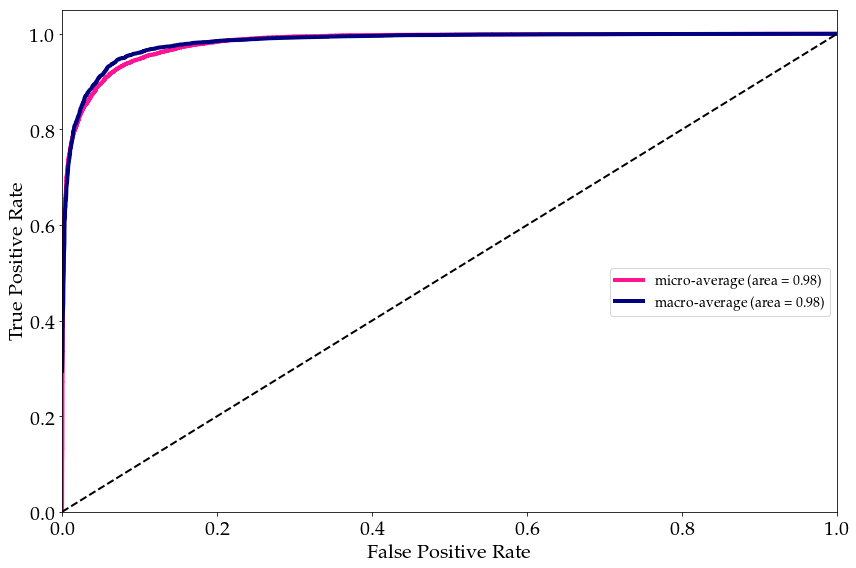

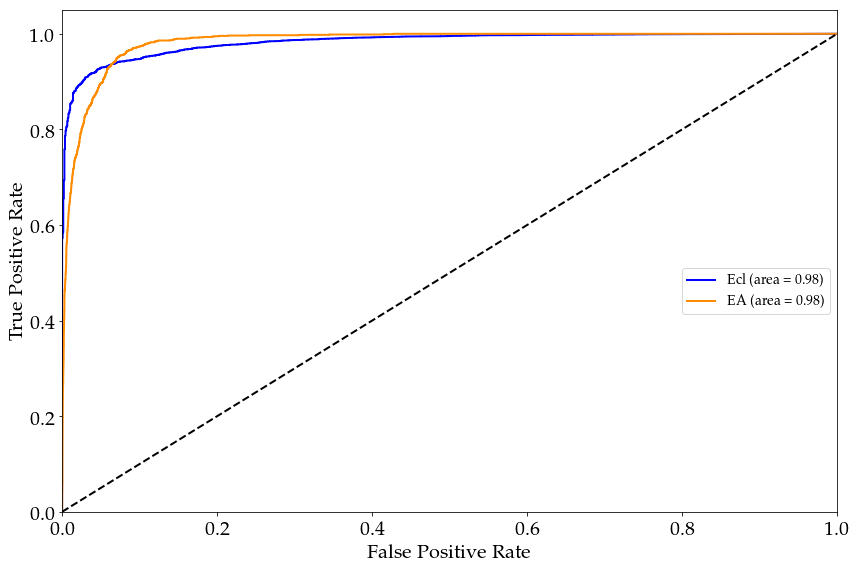

Accuracy 0.934 params {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_split': 19, 'n_estimators': 350}
Accuracy 0.933 params {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 350}
Accuracy 0.932 params {'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 250}
Accuracy 0.934 params {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_split': 13, 'n_estimators': 250}
Accuracy 0.933 params {'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 19, 'n_estimators': 250}
{'class_weight': 0, 'max_features': 0, 'min_samples_split': 17, 'n_estimators': 3}
BEST PARAMETERS: {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_split': 19, 'n_estimators': 350}
{'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_split': 19, 'n_estimators': 350}
Test set has shape (17000, 11)
Misclassified data has shape (1278, 11)
New test set has shape (1572

<Figure size 576x432 with 0 Axes>

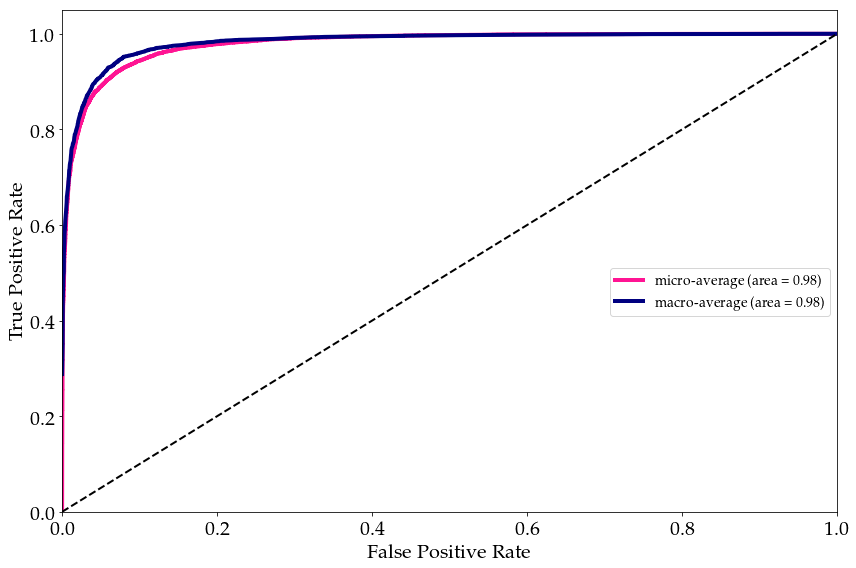

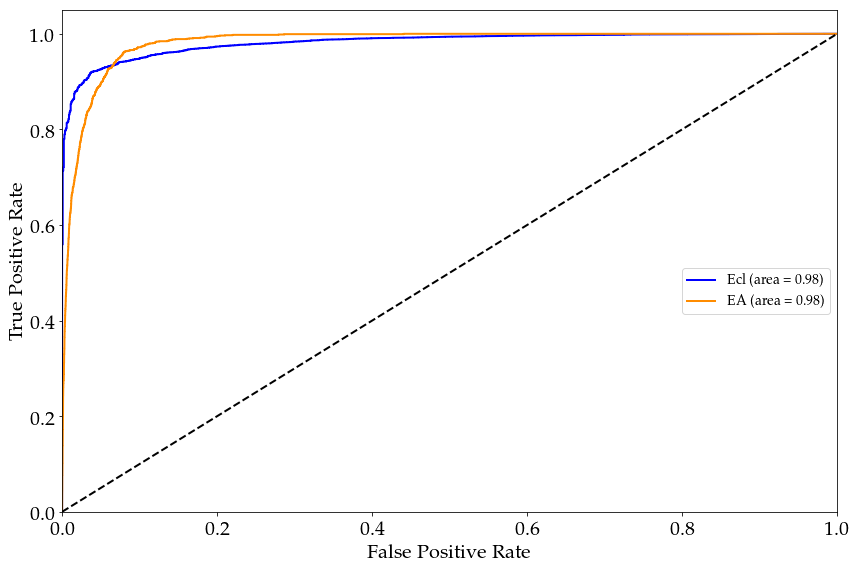

In [14]:
# XGBoost Classifier   
opt_xgb_SL_EB, fit_model_xgb_SL_EB = analysis_XGB(X_train_SL_EB, y_train_SL_EB, types_SL_EB, save_model,multi=False) # This part can be commented when no training  
ypred_xgb_SL_EB, accuracy_xgb_SL_EB, MCC_xgb_SL_EB, conf_mat_xgb_SL_EB,new_DF_xgb_SL_EB,misclassified_xgb_SL_EB,fpr_xgb_SL_EB,tpr_xgb_SL_EB,roc_auc_xgb_SL_EB = final_prediction_XGB(fit_model_xgb_SL_EB, X_train_SL_EB, y_train_SL_EB, X_test_SL_EB, y_test_SL_EB,testing_set_SL_EB, classes_types_SL_EB, types_SL_EB, nClasses_SL_EB, load_model) 

opt_rf_SL_EB, fit_model_rf_SL_EB = analysis_RF(X_train_SL_EB, y_train_SL_EB, types_SL_EB, save_model,multi=False) # This part can be commented when no training  
ypred_rf_SL_EB, accuracy_rf_SL_EB, MCC_rf_SL_EB, conf_mat_rf_SL_EB,new_DF_rf_SL_EB,misclassified_rf_SL_EB,fpr_rf_SL_EB,tpr_rf_SL_EB,roc_auc_rf_SL_EB = final_prediction_RF(fit_model_rf_SL_EB, X_train_SL_EB, y_train_SL_EB, X_test_SL_EB, y_test_SL_EB,testing_set_SL_EB, classes_types_SL_EB, types_SL_EB, nClasses_SL_EB, load_model) 


acc_xgb_SL_EB.append(accuracy_xgb_SL_EB)
mcc_xgb_SL_EB.append(MCC_xgb_SL_EB)

acc_rf_SL_EB.append(accuracy_rf_SL_EB)
mcc_rf_SL_EB.append(MCC_rf_SL_EB)

In [15]:
'-----------------------------------------------------------------------------'
                # SECOND LAYER RR LYRAE PULSATING LPV CEPHEIDS
'-----------------------------------------------------------------------------'
training_data_SL_RLCD, testing_data1_SL_RLCD, y_SL_RLCD_training_counts = second_layer_RLCD(RRab_train,RRc_train,RRd_train,blazhko_train,LPV_train,ACEP_train,cep_ii_train,delta_scuti_train,\
    RRab_test,RRc_test,RRd_test,blazhko_test,LPV_test,ACEP_test, cep_ii_test,delta_scuti_test,RR_Lyrae_label,\
    LPV_label,cepheids_label,delta_scuti_label)
testing_set_SL_RLCD = testing_data1_SL_RLCD
X_train_SL_RLCD, y_train_SL_RLCD, X_test_SL_RLCD, y_test_SL_RLCD = smote_augmentation(training_data_SL_RLCD,testing_set_SL_RLCD,label='New_label',nFeatures=nFeatures, aug_tech='SMOTE', augmentation=True)
X_tr = X_train_SL_RLCD; y_tr=y_train_SL_RLCD


RR Lyrae train has (6122, 9)
LPV train has (900, 9)
Cepheids train has (214, 9)
Delta Scuti train has (102, 9)
RR_Lyrae_test has (2628, 9)
LPV_test has (386, 9)
cepheids_test has (92, 9)
Delta Scuti test has (45, 9)
[23 24 25 26]
[6122  900  102  214]
Before OverSampling, counts of label 23: (6122,)
Before OverSampling, counts of label 24: (900,)
Before OverSampling, counts of label 25: (102,)
Before OverSampling, counts of label 26: (214,)
----------------------------------------------------------------------
After OverSampling, counts of label 23: (6122,)
After OverSampling, counts of label 24: (6122,)
After OverSampling, counts of label 25: (6122,)
After OverSampling, counts of label 26: (6122,)


Accuracy 0.995 params {'objective': 'multi:softmax', 'eta': 0.0, 'subsample': 0.4, 'max_depth': 10}
Accuracy 0.985 params {'objective': 'multi:softmax', 'eta': 0.08, 'subsample': 0.8, 'max_depth': 1}
Accuracy 0.991 params {'objective': 'multi:softmax', 'eta': 0.02, 'subsample': 0.7000000000000001, 'max_depth': 2}
Accuracy 0.996 params {'objective': 'multi:softmax', 'eta': 0.07, 'subsample': 0.5, 'max_depth': 14}
Accuracy 0.985 params {'objective': 'multi:softmax', 'eta': 0.07, 'subsample': 0.6000000000000001, 'max_depth': 1}
{'max_depth': 13, 'x_subsample': 0.5, 'eta': 0.07}
BEST PARAMETERS: {'objective': 'multi:softmax', 'eta': 0.07, 'subsample': 0.5, 'max_depth': 14}
{'objective': 'multi:softmax', 'eta': 0.07, 'subsample': 0.5, 'max_depth': 14}
Test set has shape (3151, 11)
Misclassified data has shape (44, 11)
New test set has shape (3107, 11)
Normalized confusion matrix
[[0.98782344 0.         0.00152207 0.01065449]
 [0.         0.99222798 0.         0.00777202]
 [0.02222222 0.    

<Figure size 576x432 with 0 Axes>

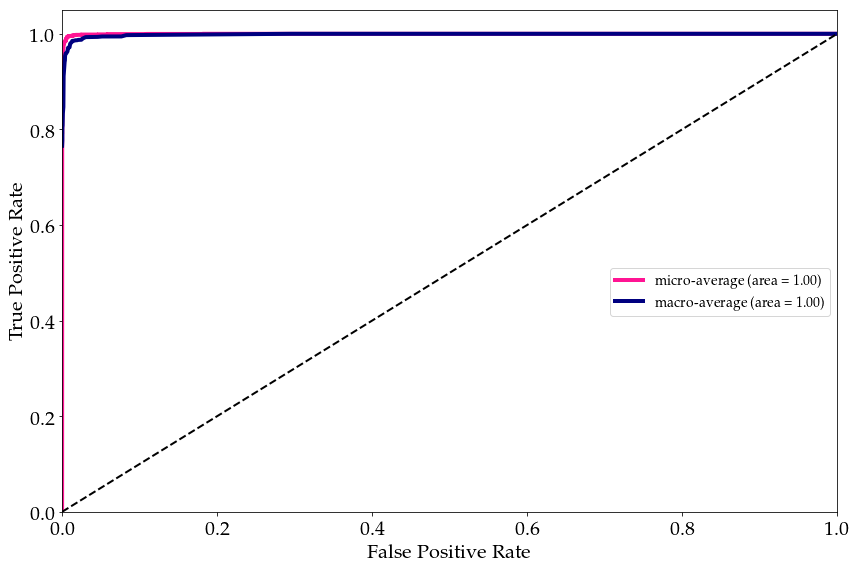

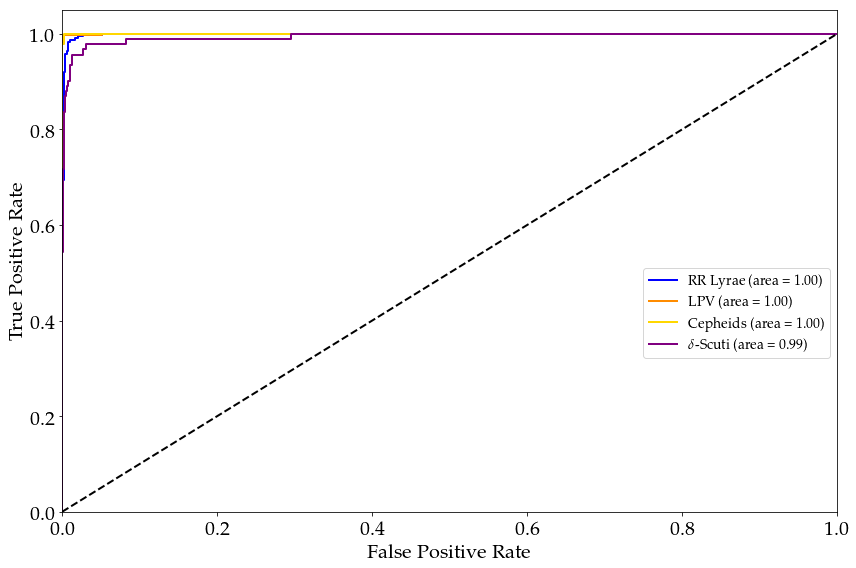

Accuracy 0.996 params {'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 350}
Accuracy 0.996 params {'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 6, 'n_estimators': 850}
Accuracy 0.996 params {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_split': 9, 'n_estimators': 950}
Accuracy 0.995 params {'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_split': 16, 'n_estimators': 150}
Accuracy 0.995 params {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_split': 16, 'n_estimators': 950}
{'class_weight': 0, 'max_features': 1, 'min_samples_split': 0, 'n_estimators': 3}
BEST PARAMETERS: {'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 350}
{'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 350}
Test set has shape (3151, 11)
Misclassified data has shape (44, 11)
New test set has shape (3107, 11)
N

<Figure size 576x432 with 0 Axes>

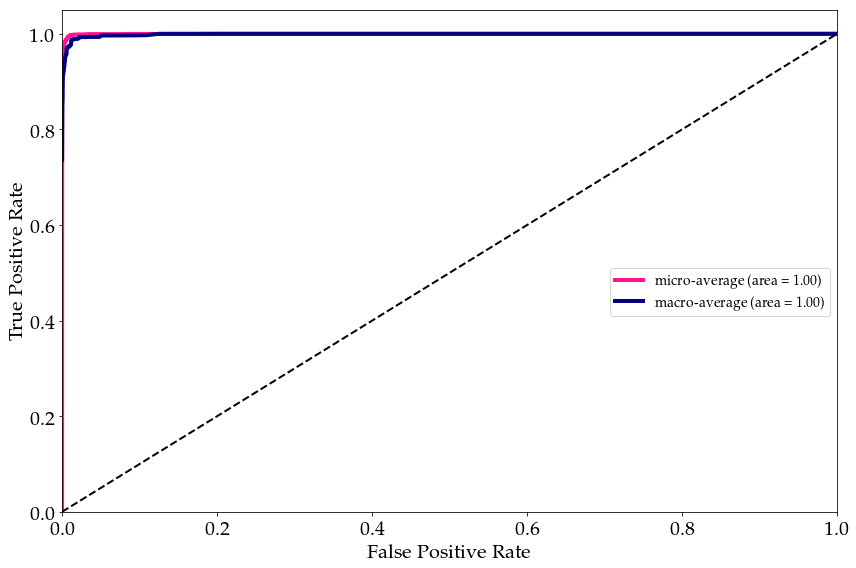

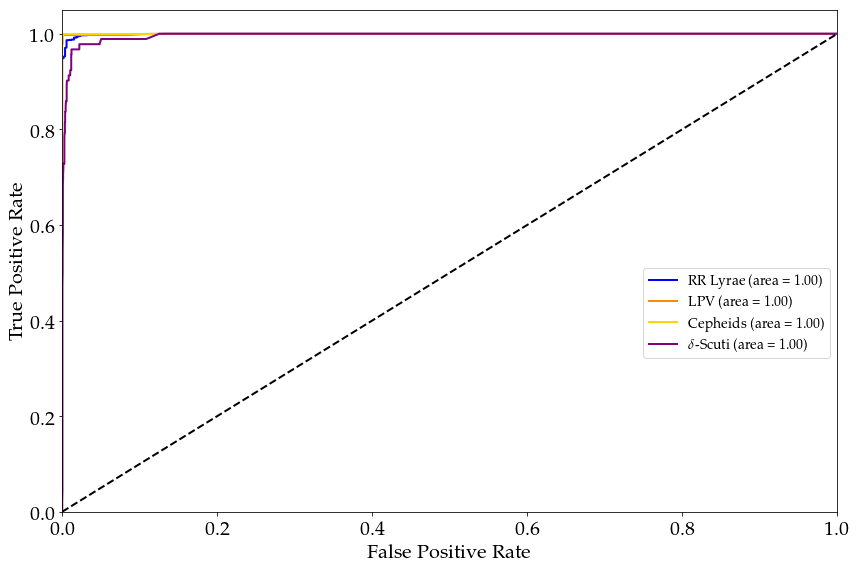

In [16]:
# XGBoost Classifier    
classes_types_SL_RLCD = ['RR Lyrae','LPV', 'Cepheids', '$\delta$-Scuti']
types_SL_RLCD         ='Type_SL_RLCD'
nClasses_SL_RLCD      = len(classes_types_SL_RLCD)

opt_xgb_SL_RLCD, fit_model_xgb_SL_RLCD = analysis_XGB(X_train_SL_RLCD, y_train_SL_RLCD, types_SL_RLCD, save_model,multi=True) # This part can be commented if you don't want to train the algorithm  
ypred_xgb_SL_RLCD, accuracy_xgb_SL_RLCD, MCC_xgb_SL_RLCD, conf_mat_xgb_SL_RLCD, new_DF_xgb_SL_RLCD,misclassified_xgb_SL_RLCD,fpr_xgb_SL_RLCD,tpr_xgb_SL_RLCD,roc_auc_xgb_SL_RLCD = final_prediction_XGB(fit_model_xgb_SL_RLCD,X_train_SL_RLCD, y_train_SL_RLCD, X_test_SL_RLCD, y_test_SL_RLCD,testing_set_SL_RLCD, classes_types_SL_RLCD, types_SL_RLCD, nClasses_SL_RLCD,load_model)

opt_rf_SL_RLCD, fit_model_rf_SL_RLCD = analysis_RF(X_train_SL_RLCD, y_train_SL_RLCD, types_SL_RLCD, save_model,multi=True) # This part can be commented if you don't want to train the algorithm  
ypred_rf_SL_RLCD, accuracy_rf_SL_RLCD, MCC_rf_SL_RLCD, conf_mat_rf_SL_RLCD, new_DF_rf_SL_RLCD,misclassified_rf_SL_RLCD,fpr_rf_SL_RLCD,tpr_rf_SL_RLCD,roc_auc_rf_SL_RLCD = final_prediction_RF(fit_model_rf_SL_RLCD,X_train_SL_RLCD, y_train_SL_RLCD, X_test_SL_RLCD, y_test_SL_RLCD,testing_set_SL_RLCD, classes_types_SL_RLCD, types_SL_RLCD, nClasses_SL_RLCD,load_model)


acc_xgb_SL_RLCD.append(accuracy_xgb_SL_RLCD)
mcc_xgb_SL_RLCD.append(MCC_xgb_SL_RLCD)

acc_rf_SL_RLCD.append(accuracy_rf_SL_RLCD)
mcc_rf_SL_RLCD.append(MCC_rf_SL_RLCD)


In [17]:
'-----------------------------------------------------------------------------'
            # THIRD LAYER RR LYRAE: RRab, RRc, RRd, Blazhko
'-----------------------------------------------------------------------------'
training_data_TL_RRLyrae, testing_data_TL_RRLyrae, y_TL_RRLyrae_training_counts = third_layer_RRLyrae(RRab_train,RRc_train,RRd_train,blazhko_train,RRab_test,RRc_test,RRd_test,blazhko_test,\
    true_class_1,true_class_2,true_class_3,true_class_4)
testing_set_TL_RL = testing_data_TL_RRLyrae

X_train_TL_RL, y_train_TL_RL,X_test_TL_RL, y_test_TL_RL = smote_augmentation(training_data_TL_RRLyrae,testing_set_TL_RL,label='True_class_labels',nFeatures=nFeatures, aug_tech='SMOTE', augmentation=True)

X_tr = X_train_TL_RL; y_tr = y_train_TL_RL


RRab train has (3026, 9)
RRc train has (2626, 9)
RRd train has (351, 9)
Blazhko train has (119, 9)
RRab test has (1299, 9)
RRc test has (1126, 9)
RRd test has (151, 9)
Blazhko test has (52, 9)
Before OverSampling, counts of label 1: (3026,)
Before OverSampling, counts of label 2: (2626,)
Before OverSampling, counts of label 3: (351,)
Before OverSampling, counts of label 4: (119,)
----------------------------------------------------------------------
After OverSampling, counts of label 1: (3026,)
After OverSampling, counts of label 2: (3026,)
After OverSampling, counts of label 3: (3026,)
After OverSampling, counts of label 4: (3026,)


Accuracy 0.935 params {'objective': 'multi:softmax', 'eta': 0.07, 'subsample': 0.5, 'max_depth': 11}
Accuracy 0.928 params {'objective': 'multi:softmax', 'eta': 0.01, 'subsample': 0.8, 'max_depth': 8}
Accuracy 0.884 params {'objective': 'multi:softmax', 'eta': 0.04, 'subsample': 0.8, 'max_depth': 4}
Accuracy 0.938 params {'objective': 'multi:softmax', 'eta': 0.02, 'subsample': 0.7000000000000001, 'max_depth': 12}
Accuracy 0.867 params {'objective': 'multi:softmax', 'eta': 0.01, 'subsample': 0.7000000000000001, 'max_depth': 3}
{'max_depth': 11, 'x_subsample': 0.7000000000000001, 'eta': 0.02}
BEST PARAMETERS: {'objective': 'multi:softmax', 'eta': 0.02, 'subsample': 0.7000000000000001, 'max_depth': 12}
{'objective': 'multi:softmax', 'eta': 0.02, 'subsample': 0.7000000000000001, 'max_depth': 12}
Test set has shape (2628, 11)
Misclassified data has shape (334, 11)
New test set has shape (2294, 11)
Normalized confusion matrix
[[0.93995381 0.         0.00384911 0.05619707]
 [0.0026643  0.8703

<Figure size 576x432 with 0 Axes>

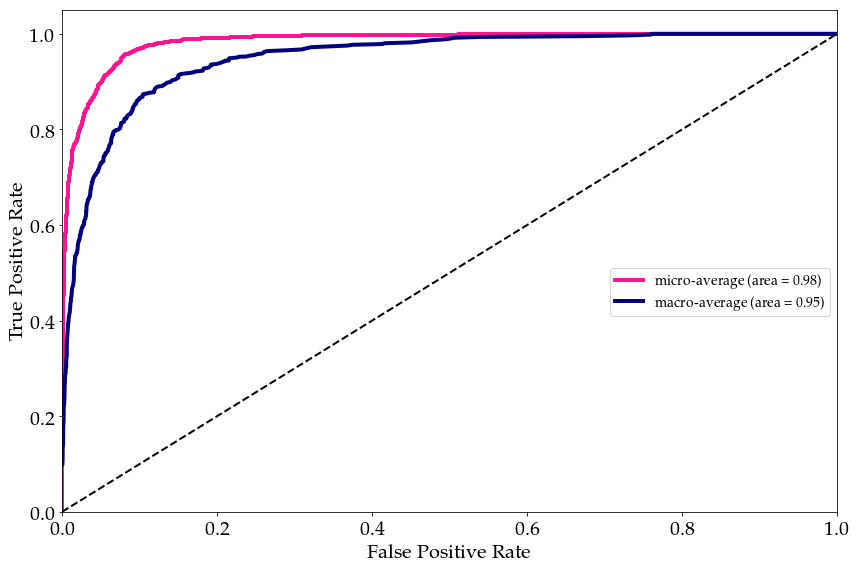

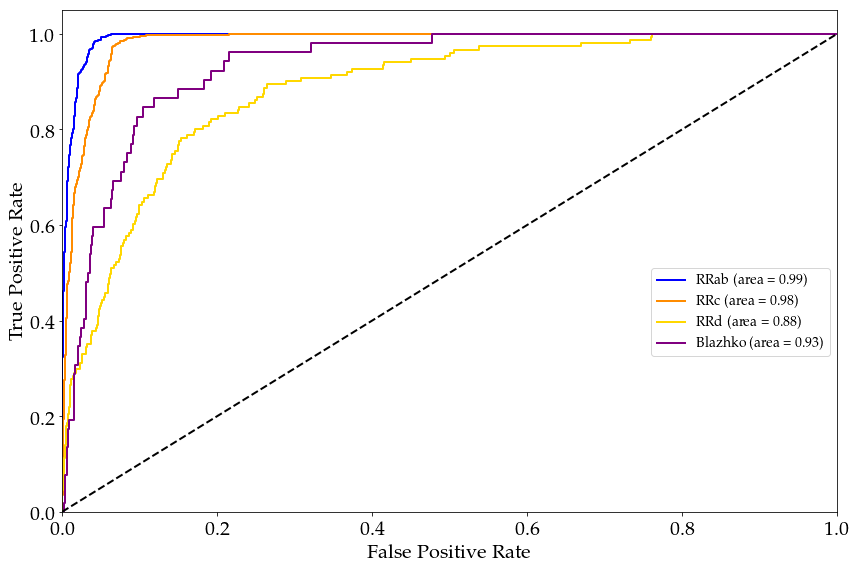

Accuracy 0.921 params {'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_split': 15, 'n_estimators': 250}
Accuracy 0.923 params {'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_split': 12, 'n_estimators': 550}
Accuracy 0.930 params {'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 450}
Accuracy 0.928 params {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_split': 9, 'n_estimators': 850}
Accuracy 0.931 params {'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 150}
{'class_weight': 0, 'max_features': 1, 'min_samples_split': 5, 'n_estimators': 1}
BEST PARAMETERS: {'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 150}
{'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 150}
Test set has shape (2628, 11)
Misclassified data has shape (318, 11)
New test set has shape (2310, 11)


<Figure size 576x432 with 0 Axes>

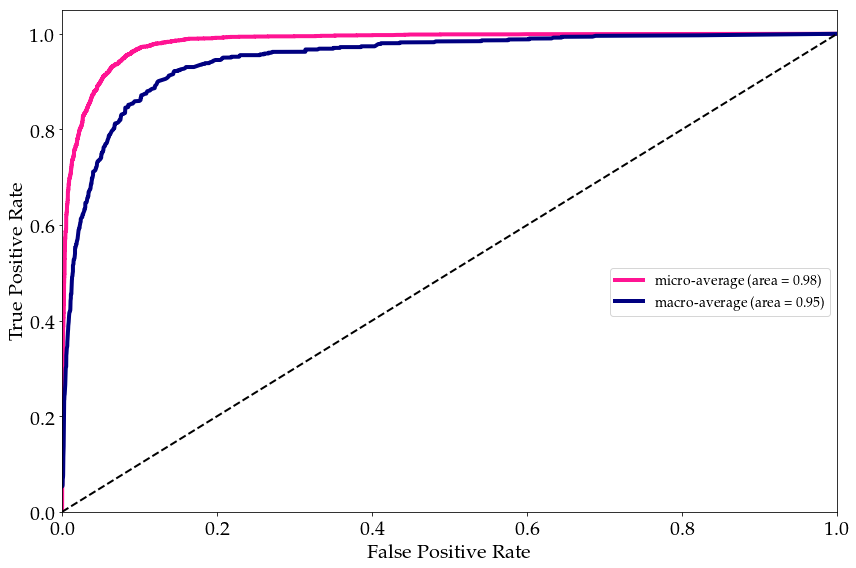

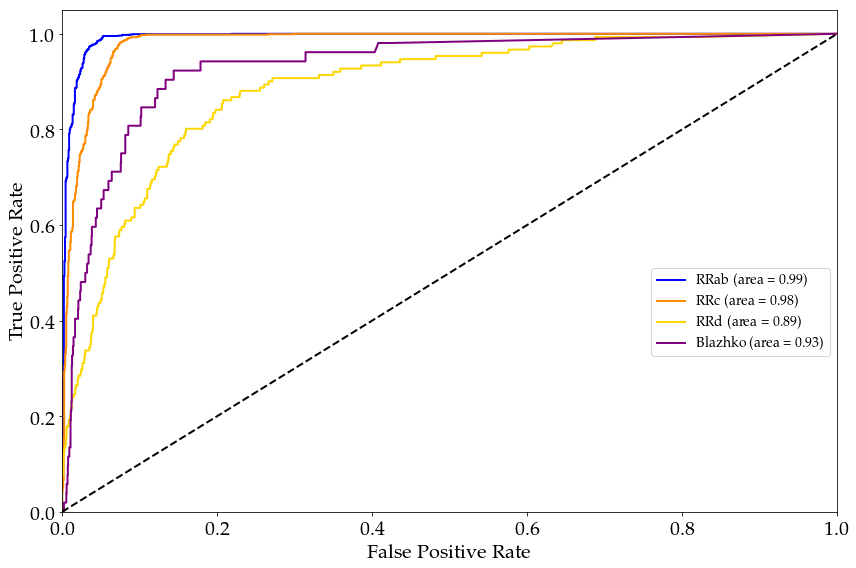

In [18]:
classes_types_TL_RL = ['RRab', 'RRc', 'RRd', "Blazhko"]
types_TL_RL         ='Type_TL_RRLyrae'
nClasses_TL_RL      = len(classes_types_TL_RL)

# XGBoost Classifier   
opt_xgb_TL_RL, fit_model_xgb_TL_RL = analysis_XGB(X_train_TL_RL, y_train_TL_RL, types_TL_RL, save_model,multi=True) # This part can be commented when no training 
ypred_xgb_TL_RL, accuracy_xgb_TL_RL, MCC_xgb_TL_RL, conf_mat_xgb_TL_RL, new_DF_xgb_TL_RL, misclassified_xgb_TL_RL,fpr_xgb_TL_RL,tpr_xgb_TL_RL,roc_auc_xgb_TL_RL = final_prediction_XGB(fit_model_xgb_TL_RL, X_train_TL_RL, y_train_TL_RL, X_test_TL_RL, y_test_TL_RL,testing_set_TL_RL, classes_types_TL_RL, types_TL_RL, nClasses_TL_RL, load_model) 

opt_rf_TL_RL, fit_model_rf_TL_RL = analysis_RF(X_train_TL_RL, y_train_TL_RL, types_TL_RL, save_model,multi=True) # This part can be commented when no training 
ypred_rf_TL_RL, accuracy_rf_TL_RL, MCC_rf_TL_RL, conf_mat_rf_TL_RL, new_DF_rf_TL_RL, misclassified_rf_TL_RL,fpr_rf_TL_RL,tpr_rf_TL_RL,roc_auc_rf_TL_RL = final_prediction_RF(fit_model_rf_TL_RL, X_train_TL_RL, y_train_TL_RL, X_test_TL_RL, y_test_TL_RL,testing_set_TL_RL, classes_types_TL_RL, types_TL_RL, nClasses_TL_RL, load_model) 


acc_xgb_TL_RL.append(accuracy_xgb_TL_RL)
mcc_xgb_TL_RL.append(MCC_xgb_TL_RL)

acc_rf_TL_RL.append(accuracy_rf_TL_RL)
mcc_rf_TL_RL.append(MCC_rf_TL_RL)


In [19]:
'-----------------------------------------------------------------------------'
                        # THIRD LAYER Cepheids: ACEP and Cep-II
'-----------------------------------------------------------------------------'
training_data_TL_cep, testing_data_TL_cep, y_TL_cep_training_counts = third_layer_Cepheids(ACEP_train,cep_ii_train,ACEP_test,cep_ii_test,true_class_10,true_class_12)
testing_set_TL_Cep = testing_data_TL_cep
X_train_TL_Cep, y_train_TL_Cep, X_test_TL_Cep, y_test_TL_Cep = smote_augmentation(training_data_TL_cep,testing_set_TL_Cep,label='True_class_labels',nFeatures=nFeatures, aug_tech='SMOTE', augmentation=True)
X_tr = X_train_TL_Cep; y_tr=y_train_TL_Cep

ACEP train has (107, 9)
Cep-II train has (107, 9)
ACEP test has (46, 9)
Cep-II test has (46, 9)
Before OverSampling, counts of label 10: (107,)
Before OverSampling, counts of label 12: (107,)
----------------------------------------------------------------------
After OverSampling, counts of label 10: (107,)
After OverSampling, counts of label 12: (107,)


Accuracy 0.864 params {'objective': 'binary:logistic', 'eta': 0.07, 'subsample': 0.4, 'max_depth': 3}
Accuracy 0.865 params {'objective': 'binary:logistic', 'eta': 0.08, 'subsample': 0.4, 'max_depth': 1}
Accuracy 0.860 params {'objective': 'binary:logistic', 'eta': 0.03, 'subsample': 0.6000000000000001, 'max_depth': 6}
Accuracy 0.878 params {'objective': 'binary:logistic', 'eta': 0.07, 'subsample': 0.5, 'max_depth': 9}
Accuracy 0.869 params {'objective': 'binary:logistic', 'eta': 0.01, 'subsample': 0.8, 'max_depth': 11}
{'max_depth': 8, 'x_subsample': 0.5, 'eta': 0.07}
BEST PARAMETERS: {'objective': 'binary:logistic', 'eta': 0.07, 'subsample': 0.5, 'max_depth': 9}
{'objective': 'binary:logistic', 'eta': 0.07, 'subsample': 0.5, 'max_depth': 9}
Test set has shape (92, 11)
Misclassified data has shape (12, 11)
New test set has shape (80, 11)
Normalized confusion matrix
[[0.91304348 0.08695652]
 [0.17391304 0.82608696]]


<Figure size 576x432 with 0 Axes>

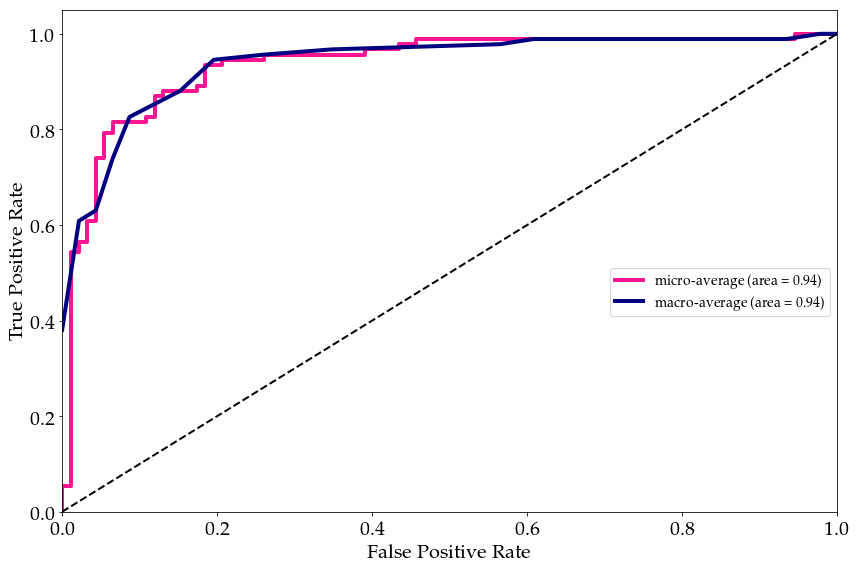

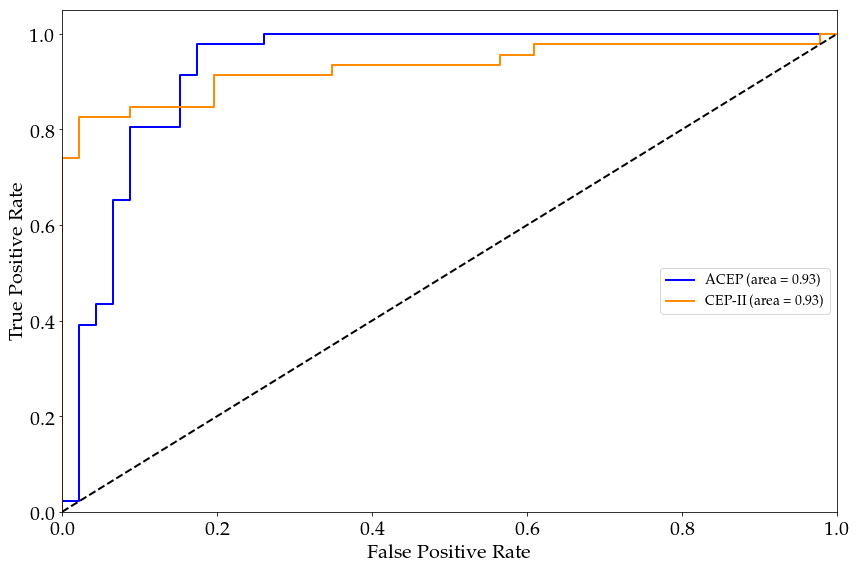

Accuracy 0.851 params {'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 350}
Accuracy 0.851 params {'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 12, 'n_estimators': 250}
Accuracy 0.860 params {'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 450}
Accuracy 0.855 params {'class_weight': 'balanced', 'max_features': 'auto', 'min_samples_split': 16, 'n_estimators': 550}
Accuracy 0.851 params {'class_weight': 'balanced', 'max_features': 'sqrt', 'min_samples_split': 17, 'n_estimators': 550}
{'class_weight': 0, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 4}
BEST PARAMETERS: {'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 450}
{'class_weight': 'balanced', 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 450}
Test set has shape (92, 11)
Misclassified data has shape (9, 11)
New test set has shape (83, 11)
Norma

<Figure size 576x432 with 0 Axes>

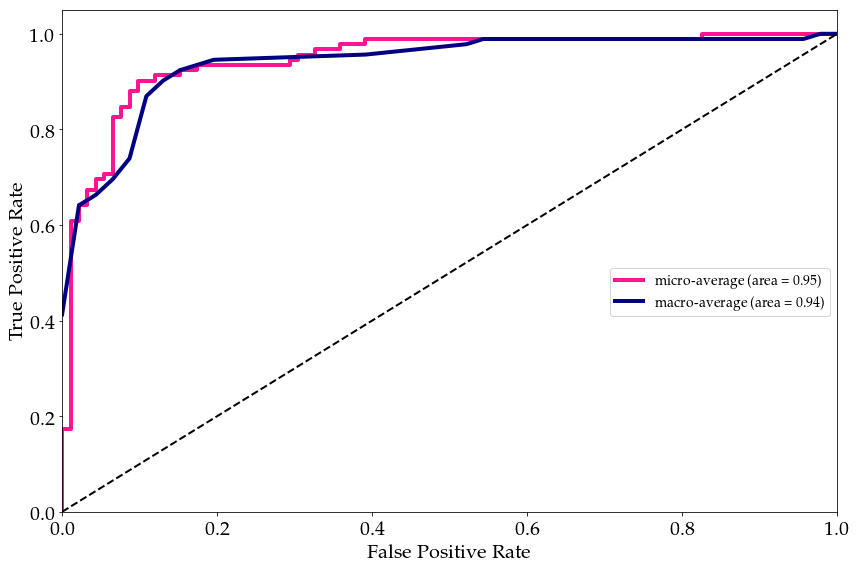

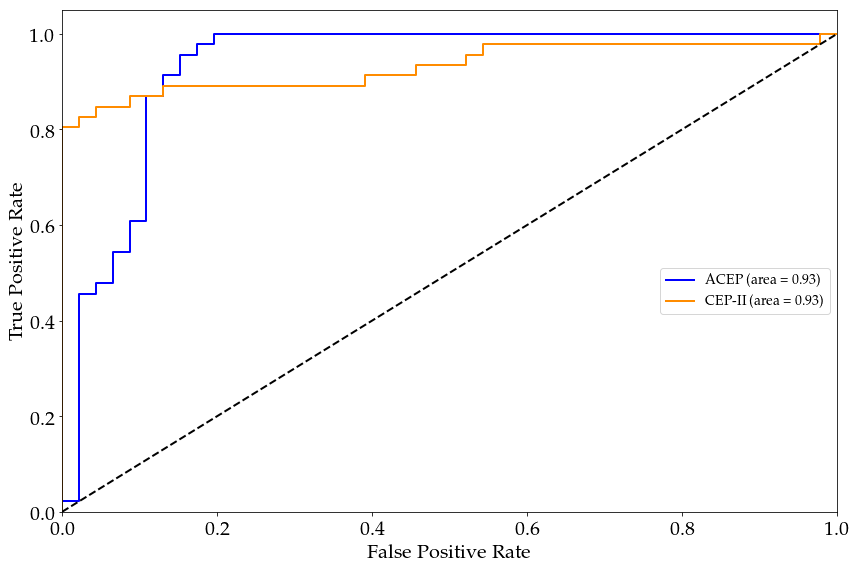

In [20]:
classes_types_TL_Cep = ['ACEP','CEP-II']
types_TL_Cep         ='Type_TL_Cepheids'
nClasses_TL_Cep      = 2

# XGBoost Classifier   
opt_xgb_TL_Cep, fit_model_xgb_TL_Cep = analysis_XGB(X_train_TL_Cep, y_train_TL_Cep, types_TL_Cep, save_model,multi=False) # This part can be commented when no training
ypred_xgb_TL_Cep, accuracy_xgb_TL_Cep, MCC_xgb_TL_Cep, conf_mat_xgb_TL_Cep, new_DF_xgb_TL_Cep, misclassified_xgb_TL_Cep,fpr_xgb_TL_Cep,tpr_xgb_TL_Cep,roc_auc_xgb_TL_Cep = final_prediction_XGB(fit_model_xgb_TL_Cep, X_train_TL_Cep, y_train_TL_Cep, X_test_TL_Cep, y_test_TL_Cep, testing_set_TL_Cep, classes_types_TL_Cep, types_TL_Cep, nClasses_TL_Cep, load_model) 

opt_rf_TL_Cep, fit_model_rf_TL_Cep = analysis_RF(X_train_TL_Cep, y_train_TL_Cep, types_TL_Cep, save_model,multi=False) # This part can be commented when no training
ypred_rf_TL_Cep, accuracy_rf_TL_Cep, MCC_rf_TL_Cep, conf_mat_rf_TL_Cep, new_DF_rf_TL_Cep, misclassified_rf_TL_Cep,fpr_rf_TL_Cep,tpr_rf_TL_Cep,roc_auc_rf_TL_Cep = final_prediction_RF(fit_model_rf_TL_Cep, X_train_TL_Cep, y_train_TL_Cep, X_test_TL_Cep, y_test_TL_Cep, testing_set_TL_Cep, classes_types_TL_Cep, types_TL_Cep, nClasses_TL_Cep, load_model) 


acc_xgb_TL_Cep.append(accuracy_xgb_TL_Cep)
mcc_xgb_TL_Cep.append(MCC_xgb_TL_Cep)

acc_rf_TL_Cep.append(accuracy_rf_TL_Cep)
mcc_rf_TL_Cep.append(MCC_rf_TL_Cep)


In [21]:
print('-'*50)


metrics = open("../results/hyperopt_hierarchical-results_SMOTE/metrics.txt", 'w')

metrics.write('='*80+'\n')
metrics.write('***Testing Phase XGBoost for ' + str(classes_types_FL) + ' ***\n')
metrics.write('='*80+'\n')
metrics.write("Accuracy: ({} ± {}) %".format(np.mean(acc_xgb_FL)*100,np.std(acc_xgb_FL)) + '\n')
metrics.write("MCC: ({} ± {})".format(np.mean(mcc_xgb_FL)*100,np.std(mcc_xgb_FL)) + '\n')

metrics.write('='*80+'\n')
metrics.write('***Testing Phase XGBoost for ' + str(classes_types_SL_EB) + ' ***\n')
metrics.write('='*80+'\n')
metrics.write("Accuracy: ({} ± {}) %".format(np.mean(acc_xgb_SL_EB)*100,np.std(acc_xgb_SL_EB)) + '\n')
metrics.write("MCC: ({} ± {})".format(np.mean(mcc_xgb_SL_EB)*100,np.std(mcc_xgb_SL_EB)) + '\n')

metrics.write('='*80+'\n')
metrics.write('***Testing Phase XGBoost for ' + str(classes_types_SL_RLCD) + ' ***\n')
metrics.write('='*80+'\n')
metrics.write("Accuracy: ({} ± {}) %".format(np.mean(acc_xgb_SL_RLCD)*100,np.std(acc_xgb_SL_RLCD)) + '\n')
metrics.write("MCC: ({} ± {})".format(np.mean(mcc_xgb_SL_RLCD)*100,np.std(mcc_xgb_SL_RLCD)) + '\n')

metrics.write('='*80+'\n')
metrics.write('***Testing Phase XGBoost for ' + str(classes_types_TL_RL) + ' ***\n')
metrics.write('='*80+'\n')
metrics.write("Accuracy: ({} ± {}) %".format(np.mean(acc_xgb_TL_RL)*100,np.std(acc_xgb_TL_RL)) + '\n')
metrics.write("MCC: ({} ± {})".format(np.mean(mcc_xgb_TL_RL)*100,np.std(mcc_xgb_TL_RL)) + '\n')

metrics.write('='*80+'\n')
metrics.write('***Testing Phase XGBoost for ' + str(classes_types_TL_Cep) + ' ***\n')
metrics.write('='*80+'\n')
metrics.write("Accuracy: ({} ± {}) %".format(np.mean(acc_xgb_TL_Cep)*100,np.std(acc_xgb_TL_Cep)) + '\n')
metrics.write("MCC: ({} ± {})".format(np.mean(mcc_xgb_TL_Cep)*100,np.std(mcc_xgb_TL_Cep)) + '\n')
metrics.close()


--------------------------------------------------
